This example notebook is adapted from the ML tutorial given by Ben nachman in the INDIA-CMS lecture series. The original notebook can be found here

https://github.com/bnachman/CMSIndiaDemo


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import StandardScaler
import random

In [3]:
import pandas as pd

Download the necessary datasets. LHCOlympics2020 R and D dataset

In [4]:
#!wget https://raw.githubusercontent.com/bnachman/CMSIndiaDemo/main/anomaly.csv
#!wget https://raw.githubusercontent.com/bnachman/CMSIndiaDemo/main/noisesimulation1.csv
#!wget https://raw.githubusercontent.com/bnachman/CMSIndiaDemo/main/noisesimulation2.csv

convert to pandas dataframe

In [5]:
df=pd.read_csv('anomaly.csv', sep=',',header=None)
df2=pd.read_csv('noisesimulation1.csv', sep=',',header=None)
df3=pd.read_csv('noisesimulation2.csv', sep=',', header=None)


In [6]:

#first feature is m_JJ, other features are jet masses and tau_21's.
sig = df.to_numpy()
back1 = df3.to_numpy() #one of these is Pythia and one is Herwig.
back2 = df2.to_numpy()


In [7]:

#Select only events in the signal region
sig = sig[(sig[:,0]>3.25)*(sig[:,0]<3.75)][:,1:5]
back1 = back1[(back1[:,0]>3.25)*(back1[:,0]<3.75)][:,1:5]
back2 = back2[(back2[:,0]>3.25)*(back2[:,0]<3.75)][:,1:5]

In [8]:
## Transforming variables
scaler = StandardScaler()
scaler.fit(back1)
sig = scaler.transform(sig)
back1 = scaler.transform(back1)
back2 = scaler.transform(back2)

##### We will first use a supervised classifier(dnn) and then compare the performance with the unsupervised model


In [9]:
X_fs = np.concatenate([sig,back1])
Y_fs = np.concatenate([np.ones(len(sig)),np.zeros(len(back1))]) # assign labels

In [10]:

X_fs_train, X_fs_test, Y_fs_train, Y_fs_test = train_test_split(X_fs,Y_fs,test_size=0.2)

In [11]:
## Fully supervised classifier

model_fs = Sequential()
model_fs.add(Dense(100,input_dim=4,activation='relu'))
model_fs.add(Dense(100,activation='relu'))
model_fs.add(Dense(100,activation='relu'))
model_fs.add(Dense(1,activation='sigmoid'))
model_fs.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_fs.summary()


model_fs.fit(X_fs_train,Y_fs_train,epochs=25,batch_size=1024)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25


2022-08-28 14:51:08.522907: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


184/184 [==============================] - 1s 4ms/step - loss: 0.3198 - accuracy: 0.8770
Epoch 2/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2358 - accuracy: 0.9098
Epoch 3/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2297 - accuracy: 0.9119
Epoch 4/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2280 - accuracy: 0.9121
Epoch 5/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2270 - accuracy: 0.9127
Epoch 6/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2259 - accuracy: 0.9131
Epoch 7/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2249 - accuracy: 0.9137
Epoch 8/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2249 - accuracy: 0.9135
Epoch 9/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2242 - accuracy: 0.9137
Epoch 10/25
184/184 [==============================] - 1s 4ms/step - loss: 0.2241 - accuracy: 0.9137
Epoch 11/2

### Plot ROC curves

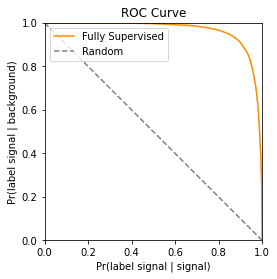

In [12]:
fpr_fs,tpr_fs,_=roc_curve(Y_fs_test,model_fs.predict(X_fs_test,batch_size=1024))

# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(tpr_fs,1.0-fpr_fs,color="darkorange",label='Fully Supervised')
plt.plot([0,1],[1,0],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")

#### Now the unsupervised autoencoder


In [13]:
## Anomaly detection

# weak supervision would be S+B versus B.  
# Let's do a simple unsupervised model, an autoencoder.

model_us = Sequential()
model_us.add(Dense(100,input_dim=4,activation='relu'))
model_us.add(Dense(4,activation='relu'))
model_us.add(Dense(100,activation='relu'))
model_us.add(Dense(4,activation='linear'))
model_us.compile(loss='mse',optimizer='adam')
model_us.summary()

X_us_train, X_us_test, Y_us_train, Y_us_test = train_test_split(back1,back1,test_size=0.3)
model_us.fit(X_us_train,Y_us_train,epochs=25,batch_size=2000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               500       
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
 dense_6 (Dense)             (None, 100)               500       
                                                                 
 dense_7 (Dense)             (None, 4)                 404       
                                                                 
Total params: 1,808
Trainable params: 1,808
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
54/54 [==============================] - 0s 3ms/step - loss: 0.7740
Epoch 2/25
54/54 [==============================] - 0s 3ms/step - loss: 0.1936
Epoch 3/25
54/54 [========

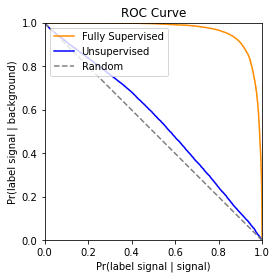

In [14]:
anomaly_score = np.linalg.norm(X_fs_test - model_us.predict(X_fs_test),axis=1)
fpr_us,tpr_us,_=roc_curve(Y_fs_test,anomaly_score)

# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(tpr_fs,1.0-fpr_fs,color="darkorange",label='Fully Supervised')
plt.plot(tpr_us,1.0-fpr_us,color="blue",label='Unsupervised')
plt.plot([0,1],[1,0],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")

##### So the performance is much worse than supervised learning but it is unsupervised/model independent